## Federated Analysis

Here we take the weights from each of the models, aggregate them and then use these with each of the studies


In [1]:
import numpy as np

def aggregate_weights_median(weights_dict):
    """
    Aggregate weights layer-wise across all studies using the median.
    """
    studies = list(weights_dict.keys())
    n_layers = len([w for w in weights_dict[studies[0]] if w is not None])

    aggregated_weights = []
    for layer_idx in range(n_layers):
        # Collect all weights for this layer across studies
        layer_weights = [weights_dict[study][layer_idx] for study in studies if weights_dict[study] is not None]

        # Stack and take median across the first axis (studies)
        stacked = np.stack(layer_weights, axis=0)
        median_weight = np.median(stacked, axis=0)
        aggregated_weights.append(median_weight)

    return aggregated_weights


In [2]:
def extract_model_weights_per_study(mse_summaries):
    weights_dict = {}

    for study in mse_summaries.keys():
        model_path = f"models/{study}_model.keras"

        try:
            model = load_model(model_path)
            weights = model.get_weights()
            weights_dict[study] = weights
        except Exception as e:
            print(f"Could not load model for {study}: {e}")
            weights_dict[study] = None

    return weights_dict


In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import os

def build_model_from_file(model_path):
    """
    Load a Keras model structure from an existing model file (without weights).
    """
    model = load_model(model_path)
    model_json = model.to_json()
    new_model = model_from_json(model_json)
    return new_model


In [4]:
def build_federated_model(aggregated_weights, reference_model_path):
    """
    Build a model with aggregated weights.
    """
    model = build_model_from_file(reference_model_path)
    model.set_weights(aggregated_weights)
    return model


In [5]:
from sklearn.metrics import mean_squared_error
import pandas as pd

def evaluate_federated_model(model, X_test, y_true, antibody_labels):
    """
    Evaluate reconstructed output from federated model.
    """
    reconstructed = model.predict(X_test)
    mse_per_ab = {}

    for i, ab in enumerate(antibody_labels):
        mse = mean_squared_error(y_true[:, i], reconstructed[:, i])
        mse_per_ab[ab] = mse

    mse_median = np.median(list(mse_per_ab.values()))
    mse_iqr = np.subtract(*np.percentile(list(mse_per_ab.values()), [75, 25]))

    print(f"Federated Model MSE (median): {mse_median:.4f}")
    print(f"IQR: {mse_iqr:.4f}")
    print("Per-Autoantibody MSE:")
    print(pd.Series(mse_per_ab).sort_values())

    return {
        "mse_median": mse_median,
        "mse_iqr": mse_iqr,
        "per_antibody_mse": mse_per_ab,
        "reconstructed": reconstructed
    }


In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def evaluate_federated_model(federated_model, mse_summaries, study):
    summary = mse_summaries[study]
    
    X_test = summary["X_test"]
    antibodies = summary["antibody_labels"]
    age_groups = summary["Age_Group"]
    sex = summary["Sex"]

    # Reshape for CNN
    X_test_reshaped = X_test.reshape((-1, X_test.shape[1], 1, 1))
    
    # Predict
    reconstructed = federated_model.predict(X_test_reshaped)

    # Flatten CNN output
    reconstructed_flat = reconstructed.reshape(X_test.shape)

    # Overall MSE
    mse = mean_squared_error(X_test, reconstructed_flat)
    
    # Per-antibody MSE
    per_ab_mse = {
        ab: mean_squared_error(X_test[:, i], reconstructed_flat[:, i])
        for i, ab in enumerate(antibodies)
    }

    # Median of per-antibody MSEs
    mse_median = np.median(list(per_ab_mse.values()))
    mse_iqr = np.subtract(*np.percentile(list(per_ab_mse.values()), [75, 25]))

    # Build DataFrames (MUST use flattened arrays)
    df = pd.DataFrame(X_test, columns=antibodies)
    df["Age_Group"] = age_groups
    df["Sex"] = sex

    df_recon = pd.DataFrame(reconstructed_flat, columns=antibodies)
    df_recon["Age_Group"] = age_groups
    df_recon["Sex"] = sex

    # MSE by age group
    mse_by_age = df.groupby("Age_Group").apply(
        lambda g: mean_squared_error(
            g[antibodies], df_recon.loc[g.index, antibodies]
        )
    ).to_dict()

    # MSE by sex
    mse_by_sex = df.groupby("Sex").apply(
        lambda g: mean_squared_error(
            g[antibodies], df_recon.loc[g.index, antibodies]
        )
    ).to_dict()

    return {
        "mse": mse,
        "mse_median": mse_median,
        "mse_iqr": mse_iqr,
        "per_antibody_mse": per_ab_mse,
        "mse_by_age_group": mse_by_age,
        "mse_by_sex": mse_by_sex,
        "N_test": len(X_test),
        "y_true": X_test,
        "y_pred": reconstructed_flat,
    }


In [7]:
import os
# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [8]:
import pickle

# Load mse_summaries from file
with open("mse_summaries.pkl", "rb") as f:
    mse_summaries = pickle.load(f)

# Confirm structure
print(mse_summaries.keys())


dict_keys(['SDY569', 'SDY1625', 'SDY524', 'SDY797', 'SDY1737'])


In [9]:
# === Run this
study_list = ["SDY569", "SDY1625", "SDY524", "SDY797", "SDY1737"]
weights_dict = extract_model_weights_per_study(mse_summaries)

In [10]:
# 1. Aggregate the weights
aggregated_weights = aggregate_weights_median(weights_dict)

# 2. Build federated model using any of the saved models as architecture reference
reference_model_path = "models/SDY569_model.keras"  # or any other
federated_model = build_federated_model(aggregated_weights, reference_model_path)



In [11]:
federated_results = {}
for study in mse_summaries:
    print(f"Evaluating federated model on {study}...")
    federated_results[study] = evaluate_federated_model(federated_model, mse_summaries, study)


Evaluating federated model on SDY569...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Evaluating federated model on SDY1625...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Evaluating federated model on SDY524...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluating federated model on SDY797...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluating federated model on SDY1737...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:4

from pprint import pprint
pprint(federated_results[study_list[0]])

In [12]:
comparison_data = []

for study in mse_summaries:
    local_mse = mse_summaries[study]["mse_median"]
    fed_mse = federated_results[study]["mse"]
    delta = local_mse - fed_mse
    pct_improvement = (delta / local_mse) * 100

    comparison_data.append({
        "Study": study,
        "Local MSE": round(local_mse, 4),
        "Federated MSE": round(fed_mse, 4),
        "Δ MSE": round(delta, 4),
        "% Improvement": f"{pct_improvement:.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)


,Study,Local MSE,Federated MSE,Δ MSE,% Improvement
0,SDY569,0.0018,0.0543,-0.0525,-2997.47%
1,SDY1625,0.0013,0.0313,-0.0300,-2266.48%
2,SDY524,0.0151,0.1130,-0.0979,-646.66%
3,SDY797,0.0994,0.3567,-0.2573,-258.90%
4,SDY1737,0.0259,0.0381,-0.0122,-47.05%


## Retrain Federated Model on Each Study and Evaluate Stratified MSE

In [13]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
import numpy as np

# Store results after retraining
retrain_detailed_results = {}

for study in study_list:
    print(f"\n--- Retraining Federated Model on Study: {study} ---")

    summary = mse_summaries[study]
    
    # Extract X_train and reshape only relevant features
    X_train = summary["X_train"]
    antibodies = summary["antibody_labels"]

    # Number of features used in training (including one-hot encoded Age_Group and Sex)
    n_features_used = federated_model.input_shape[1]

    # Defensive check
    if X_train.shape[1] != n_features_used:
        print(f"  ⚠ Reshaping X_train: expected {n_features_used}, got {X_train.shape[1]}")
        # Try to truncate or slice appropriately
        X_train = X_train[:, :n_features_used]

    # Reshape for CNN input
    X_train_reshaped = X_train.reshape((-1, n_features_used, 1, 1))

    # Clone the federated model and copy weights
    local_model = clone_model(federated_model)
    local_model.set_weights(federated_model.get_weights())
    local_model.compile(optimizer=Adam(), loss='mse')

    # Retrain
    local_model.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=8, verbose=1)

    # Evaluate after retraining
    results_post = evaluate_federated_model(local_model, mse_summaries, study)
    retrain_detailed_results[study] = results_post



--- Retraining Federated Model on Study: SDY569 ---
  ⚠ Reshaping X_train: expected 7, got 12
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.0774
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0768
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0761
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0755
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0748
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0742
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0735
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0728
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0722
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0715
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

--- Retraining Federated Model on Study: SDY1625 ---
  ⚠ Reshaping X_train: expected 7, got 10
Epoch 1/10


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265  
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0262
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0249
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

--- Retraining Federated Model on Study: SDY524 ---
  ⚠ Reshaping X_train: expected 7, got 12
Epoch 1/10


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0872  
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.0807
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 0.0736
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 0.0675
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.0612
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.0558
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 0.0509
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.0467
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 0.0435
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.0406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

--- Retraining Federated Model on Study: SDY797 ---
  ⚠ Reshaping X_train: expected 7, got 10
Epoch 1/10


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3964  
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3799
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3622
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3443
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3236
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3031
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2816
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2595
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2368
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2167
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

--- Retraining Federated Model on Study: SDY1737 ---
  ⚠ Reshaping X_train: expected 7, got 13
Epoch 1/10


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0951  
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0940
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0927
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0915
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0903
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0892
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0879
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0868
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0856
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


In [14]:
retrain_detailed_results = {}

for study in study_list:
    summary = mse_summaries[study]
    X_train = summary["X_train"]
    n_features_used = federated_model.input_shape[1]
    
    if X_train.shape[1] != n_features_used:
        X_train = X_train[:, :n_features_used]
    
    X_train_reshaped = X_train.reshape((-1, n_features_used, 1, 1))
    
    # Clone & compile model
    local_model = clone_model(federated_model)
    local_model.set_weights(federated_model.get_weights())
    local_model.compile(optimizer=Adam(), loss='mse')
    
    # Retrain
    local_model.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=8, verbose=0)
    
    # Evaluate and save
    results_post = evaluate_federated_model(local_model, mse_summaries, study)
    retrain_detailed_results[study] = results_post


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age = df.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_24196/3448586870.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df.groupby("Sex").apply(


In [15]:
from pprint import pprint
pprint(retrain_detailed_results[study_list[0]])


{'N_test': 2,
 'mse': 0.05217498376820591,
 'mse_by_age_group': {'18-30': 0.016530993304078864,
                      '8-12': 0.08781897423233295},
 'mse_by_sex': {'Female': 0.08781897423233295, 'Male': 0.016530993304078864},
 'mse_iqr': 0.0032008526705752417,
 'mse_median': 0.0038854494317471086,
 'per_antibody_mse': {'GAD65': 0.34020171187091036,
                      'IA2IC': 0.008787969068815911,
                      'ICA': 0.0018667383779904859,
                      'MIAA': 0.0038854494317471086,
                      'PAD_0': 0.003222182340907667,
                      'PAD_1': 0.0032124583369138177,
                      'ZNT8': 0.004048376950156057},
 'y_pred': array([[0.08703808, 0.11151139, 0.09746014, 0.04263858, 0.06333131,
        0.05705341, 0.05694281],
       [0.08535767, 0.11034776, 0.09767039, 0.04376561, 0.06392104,
        0.05647365, 0.05641306]], dtype=float32),
 'y_true': array([[0.85849057, 0.02631579, 0.10047847, 0.        , 0.        ,
        0.        , 0.

In [16]:
pprint(mse_summaries[study_list[0]])


{'Age_Group': array(['8-12', '18-30'], dtype=object),
 'Sex': array(['Female', 'Male'], dtype=object),
 'X_test': array([[0.85849057, 0.02631579, 0.10047847, 0.        , 0.        ,
        0.        , 0.        ],
       [0.37735849, 0.00877193, 0.00956938, 0.        , 0.        ,
        0.        , 0.        ]]),
 'X_train': array([[0.28301887, 0.48245614, 0.10526316, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        ],
       [0.00943396, 0.63157895, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 0.        ],
       [0.73584906, 0.00877193, 0.00956938, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        ],
       [0.29528302, 0.23684211, 0.02870813, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.     

In [17]:
import pandas as pd

rows = []

for study in study_list:
    try:
        fed_mse = mse_summaries[study]["mse_median"]
        retrain_mse = retrain_detailed_results[study]["mse_median"]

        rows.append({
            "Study": study,
            "Federated MSE (Median)": round(fed_mse, 6),
            "Retrained MSE (Median)": round(retrain_mse, 6),
            "Δ MSE": round(retrain_mse - fed_mse, 6),
            "% Change": round(100 * (retrain_mse - fed_mse) / fed_mse, 2)
        })
    except KeyError as e:
        print(f"Missing key {e} for study {study}")

df_summary = pd.DataFrame(rows)
df_summary


,Study,Federated MSE (Median),Retrained MSE (Median),Δ MSE,% Change
0,SDY569,0.001753,0.003885,0.002132,121.64
1,SDY1625,0.001324,0.003583,0.002259,170.58
2,SDY524,0.015140,0.076508,0.061369,405.35
3,SDY797,0.099377,0.164647,0.065270,65.68
4,SDY1737,0.025936,0.004929,-0.021006,-80.99


In [18]:
import pandas as pd

rows = []

for study in study_list:
    local_mse = mse_summaries[study]["mse_median"]
    federated_mse = federated_results[study]["mse_median"]
    retrained_mse = retrain_detailed_results[study]["mse_median"]

    rows.append({
        "Study": study,
        "Local MSE": round(local_mse, 6),
        "Federated MSE": round(federated_mse, 6),
        "Retrained MSE": round(retrained_mse, 6),
        "Δ Fed - Local": round(federated_mse - local_mse, 6),
        "Δ Retrain - Local": round(retrained_mse - local_mse, 6),
    })

df_mse_comparison = pd.DataFrame(rows)
df_mse_comparison


,Study,Local MSE,Federated MSE,Retrained MSE,Δ Fed - Local,Δ Retrain - Local
0,SDY569,0.001753,0.002586,0.003885,0.000833,0.002132
1,SDY1625,0.001324,0.003595,0.003583,0.002271,0.002259
2,SDY524,0.015140,0.056944,0.076508,0.041804,0.061369
3,SDY797,0.099377,0.452137,0.164647,0.352761,0.065270
4,SDY1737,0.025936,0.002536,0.004929,-0.023400,-0.021006


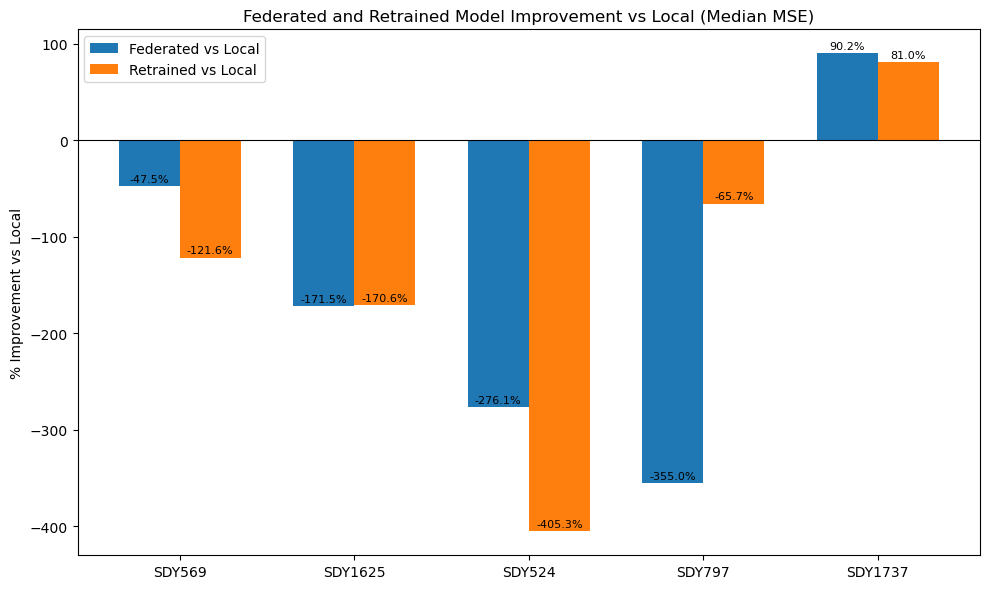

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Compute % improvement columns
df_mse_comparison["% Improvement (Federated vs Local)"] = (
    (df_mse_comparison["Local MSE"] - df_mse_comparison["Federated MSE"]) / df_mse_comparison["Local MSE"]
) * 100

df_mse_comparison["% Improvement (Retrained vs Local)"] = (
    (df_mse_comparison["Local MSE"] - df_mse_comparison["Retrained MSE"]) / df_mse_comparison["Local MSE"]
) * 100

# Set up bar plot
x = np.arange(len(df_mse_comparison["Study"]))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2,
               df_mse_comparison["% Improvement (Federated vs Local)"],
               width, label="Federated vs Local")

bars2 = ax.bar(x + width/2,
               df_mse_comparison["% Improvement (Retrained vs Local)"],
               width, label="Retrained vs Local")

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', fontsize=8)

# Labels and formatting
ax.set_ylabel('% Improvement vs Local')
ax.set_title('Federated and Retrained Model Improvement vs Local (Median MSE)')
ax.set_xticks(x)
ax.set_xticklabels(df_mse_comparison["Study"])
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()
plt.tight_layout()
plt.show()



In [20]:
# Save final MSE summary DataFrame to CSV
df_mse_comparison.to_csv("mse_comparison_summary.csv", index=False)


In [21]:
mse_summaries[study]["per_antibody_mse"]


{'GAD65': 0.02593562005038397,
 'IA2IC': 0.12690254886140245,
 'MIAA': 0.07259972263421474,
 'ICA': 0.00047365353162908547,
 'ZNT8': 0.02901191840103412,
 'PAD_0': 0.0005265164053572906,
 'PAD_1': 0.00039256751846594024}

In [22]:
study_list = ["SDY569", "SDY1625", "SDY524", "SDY797", "SDY1737"]


In [23]:
import pandas as pd
import numpy as np



# === Per-Antibody MSE Table ===
antibody_rows = []

for study in study_list:
    local_ab = mse_summaries[study]["per_antibody_mse"]
    fed_ab = federated_results[study]["per_antibody_mse"]
    retrain_ab = retrain_detailed_results[study]["per_antibody_mse"]

    for ab in local_ab:
        local = local_ab.get(ab, np.nan)
        fed = fed_ab.get(ab, np.nan)
        retrained = retrain_ab.get(ab, np.nan)

        antibody_rows.append({
            "Study": study,
            "Antibody": ab,
            "Local MSE": local,
            "Federated MSE": fed,
            "Retrained MSE": retrained,
            "Δ Fed - Local": fed - local,
            "Δ Retrain - Local": retrained - local,
            "% Improvement (Fed vs Local)": ((local - fed) / local * 100) if local else np.nan,
            "% Improvement (Retrain vs Local)": ((local - retrained) / local * 100) if local else np.nan
        })

df_antibody_mse = pd.DataFrame(antibody_rows)

# === Sex-wise MSE (Federated) ===
sex_rows = []

for study in study_list:
    for sex, val in federated_results[study]["mse_by_sex"].items():
        sex_rows.append({
            "Study": study,
            "Sex": sex,
            "Federated MSE": val
        })

df_sex_mse = pd.DataFrame(sex_rows)

# === Age-group MSE (Federated) ===
age_rows = []

for study in study_list:
    for age, val in federated_results[study]["mse_by_age_group"].items():
        age_rows.append({
            "Study": study,
            "Age_Group": age,
            "Federated MSE": val
        })

df_age_mse = pd.DataFrame(age_rows)

# Display all
from IPython.display import display
display(df_antibody_mse)
display(df_sex_mse)
display(df_age_mse)


,Study,Antibody,Local MSE,Federated MSE,Retrained MSE,Δ Fed - Local,Δ Retrain - Local,% Improvement (Fed vs Local),% Improvement (Retrain vs Local)
0,SDY569,GAD65,0.255909,0.363614,0.340202,0.107705,0.084293,-42.087333,-32.938595
1,SDY569,IA2IC,0.001753,0.003841,0.008788,0.002088,0.007035,-119.125988,-401.302776
2,SDY569,MIAA,0.002094,0.002586,0.003885,0.000491,0.001791,-23.466194,-85.537451
3,SDY569,ICA,0.000812,0.001871,0.001867,0.001059,0.001055,-130.441355,-129.868986
4,SDY569,ZNT8,0.002542,0.003376,0.004048,0.000833,0.001506,-32.777882,-59.237296
5,SDY569,PAD_0,0.000281,0.002277,0.003222,0.001996,0.002941,-710.187559,-1046.419114
6,SDY569,PAD_1,0.000078,0.002531,0.003212,0.002454,0.003135,-3156.117426,-4032.164620
7,SDY1625,GAD65,0.005974,0.003595,0.003583,-0.002378,-0.002390,39.815612,40.016090
8,SDY1625,IA2IC,0.089452,0.134401,0.130773,0.044949,0.041321,-50.249819,-46.193809
9,SDY1625,MIAA,0.000992,0.008665,0.003672,0.007673,0.002679,-773.465873,-270.105540


,Study,Sex,Federated MSE
0,SDY569,Female,0.091871
1,SDY569,Male,0.016728
2,SDY1625,Female,0.003793
3,SDY1625,Male,0.058882
4,SDY524,Female,0.122037
5,SDY524,Male,0.108544
6,SDY797,Female,0.233389
7,SDY797,Male,0.387485
8,SDY1737,Female,0.047524
9,SDY1737,Male,0.009985


,Study,Age_Group,Federated MSE
0,SDY569,18-30,0.016728
1,SDY569,8-12,0.091871
2,SDY1625,8-12,0.031338
3,SDY524,13-17,0.125122
4,SDY524,8-12,0.108649
5,SDY797,8-12,0.356666
6,SDY1737,13-17,0.026612
7,SDY1737,8-12,0.049666


In [24]:
import pandas as pd
import numpy as np

antibody_rows = []

for study in study_list:
    local_ab = mse_summaries[study]["per_antibody_mse"]
    fed_ab = federated_results[study]["per_antibody_mse"]
    retr_ab = retrain_detailed_results[study]["per_antibody_mse"]

    for ab in local_ab.keys():
        local = local_ab.get(ab, np.nan)
        fed = fed_ab.get(ab, np.nan)
        retr = retr_ab.get(ab, np.nan)

        antibody_rows.append({
            "Study": study,
            "Antibody": ab,
            "Local MSE (median)": local,
            "Federated MSE (median)": fed,
            "Retrained MSE (median)": retr,
            "Δ Fed − Local": fed - local,
            "Δ Retrain − Local": retr - local,
            "% Improvement Fed vs Local": ((local - fed) / local * 100) if local > 0 else np.nan,
            "% Improvement Retrain vs Local": ((local - retr) / local * 100) if local > 0 else np.nan,
        })

df_antibody_mse = pd.DataFrame(antibody_rows)


In [25]:
from sklearn.metrics import mean_squared_error

sex_rows = []

for study in study_list:
    summary = mse_summaries[study]

    X_true = summary["X_test"]
    X_recon_local = summary["reconstructed"]
    sex_labels = summary["Sex"]

    for sex in np.unique(sex_labels):
        idx = sex_labels == sex

        # Local (median of squared error)
        local_mse = np.median((X_true[idx] - X_recon_local[idx]) ** 2)

        # Federated (already computed)
        fed_mse = federated_results[study]["mse_by_sex"].get(sex, np.nan)

        # Retrained (already computed)
        retr_mse = retrain_detailed_results[study]["mse_by_sex"].get(sex, np.nan)

        sex_rows.append({
            "Study": study,
            "Sex": sex,
            "Local MSE (median)": local_mse,
            "Federated MSE (median)": fed_mse,
            "Retrained MSE (median)": retr_mse,
            "Δ Fed − Local": fed_mse - local_mse,
            "Δ Retrain − Local": retr_mse - local_mse,
        })

df_sex_mse = pd.DataFrame(sex_rows)


In [26]:
age_rows = []

for study in study_list:
    summary = mse_summaries[study]

    X_true = summary["X_test"]
    X_recon_local = summary["reconstructed"]
    age_labels = summary["Age_Group"]

    for age in np.unique(age_labels):
        idx = age_labels == age

        # Local
        local_mse = np.median((X_true[idx] - X_recon_local[idx]) ** 2)

        # Federated
        fed_mse = federated_results[study]["mse_by_age_group"].get(age, np.nan)

        # Retrained
        retr_mse = retrain_detailed_results[study]["mse_by_age_group"].get(age, np.nan)

        age_rows.append({
            "Study": study,
            "Age_Group": age,
            "Local MSE (median)": local_mse,
            "Federated MSE (median)": fed_mse,
            "Retrained MSE (median)": retr_mse,
            "Δ Fed − Local": fed_mse - local_mse,
            "Δ Retrain − Local": retr_mse - local_mse,
        })

df_age_mse = pd.DataFrame(age_rows)


In [27]:
from IPython.display import display

display(df_antibody_mse)
display(df_sex_mse)
display(df_age_mse)

df_antibody_mse.to_csv("per_antibody_mse_median.csv", index=False)
df_sex_mse.to_csv("per_sex_mse_median.csv", index=False)
df_age_mse.to_csv("per_age_group_mse_median.csv", index=False)


,Study,Antibody,Local MSE (median),Federated MSE (median),Retrained MSE (median),Δ Fed − Local,Δ Retrain − Local,% Improvement Fed vs Local,% Improvement Retrain vs Local
0,SDY569,GAD65,0.255909,0.363614,0.340202,0.107705,0.084293,-42.087333,-32.938595
1,SDY569,IA2IC,0.001753,0.003841,0.008788,0.002088,0.007035,-119.125988,-401.302776
2,SDY569,MIAA,0.002094,0.002586,0.003885,0.000491,0.001791,-23.466194,-85.537451
3,SDY569,ICA,0.000812,0.001871,0.001867,0.001059,0.001055,-130.441355,-129.868986
4,SDY569,ZNT8,0.002542,0.003376,0.004048,0.000833,0.001506,-32.777882,-59.237296
5,SDY569,PAD_0,0.000281,0.002277,0.003222,0.001996,0.002941,-710.187559,-1046.419114
6,SDY569,PAD_1,0.000078,0.002531,0.003212,0.002454,0.003135,-3156.117426,-4032.164620
7,SDY1625,GAD65,0.005974,0.003595,0.003583,-0.002378,-0.002390,39.815612,40.016090
8,SDY1625,IA2IC,0.089452,0.134401,0.130773,0.044949,0.041321,-50.249819,-46.193809
9,SDY1625,MIAA,0.000992,0.008665,0.003672,0.007673,0.002679,-773.465873,-270.105540


,Study,Sex,Local MSE (median),Federated MSE (median),Retrained MSE (median),Δ Fed − Local,Δ Retrain − Local
0,SDY569,Female,0.001187,0.091871,0.087819,0.090684,0.086632
1,SDY569,Male,0.002082,0.016728,0.016531,0.014646,0.014449
2,SDY1625,Female,0.001192,0.003793,0.001856,0.002601,0.000664
3,SDY1625,Male,0.001193,0.058882,0.056012,0.057690,0.054819
4,SDY524,Female,0.001790,0.122037,0.047556,0.120247,0.045766
5,SDY524,Male,0.001472,0.108544,0.052587,0.107073,0.051116
6,SDY797,Female,0.069088,0.233389,0.143017,0.164301,0.073930
7,SDY797,Male,0.043268,0.387485,0.195237,0.344217,0.151969
8,SDY1737,Female,0.021635,0.047524,0.042418,0.025888,0.020783
9,SDY1737,Male,0.000226,0.009985,0.011362,0.009759,0.011135


,Study,Age_Group,Local MSE (median),Federated MSE (median),Retrained MSE (median),Δ Fed − Local,Δ Retrain − Local
0,SDY569,18-30,0.002082,0.016728,0.016531,0.014646,0.014449
1,SDY569,8-12,0.001187,0.091871,0.087819,0.090684,0.086632
2,SDY1625,8-12,0.001193,0.031338,0.028934,0.030145,0.027741
3,SDY524,13-17,0.003377,0.125122,0.063911,0.121744,0.060534
4,SDY524,8-12,0.001310,0.108649,0.046182,0.107339,0.044872
5,SDY797,8-12,0.054593,0.356666,0.184793,0.302073,0.130200
6,SDY1737,13-17,0.018981,0.026612,0.025958,0.007631,0.006977
7,SDY1737,8-12,0.015656,0.049666,0.043350,0.034010,0.027694


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure % improvement columns are numeric
df_antibody_mse["% Improvement (Fed vs Local)"] = pd.to_numeric(
    df_antibody_mse["% Improvement (Fed vs Local)"], errors="coerce"
)
df_antibody_mse["% Improvement (Retrain vs Local)"] = pd.to_numeric(
    df_antibody_mse["% Improvement (Retrain vs Local)"], errors="coerce"
)

# Plot: Per-Antibody % Improvement (Federated vs Local)
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_antibody_mse,
    x="Antibody",
    y="% Improvement (Fed vs Local)",
    hue="Study"
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Per-Antibody % Improvement (Federated vs Local)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Per-Antibody % Improvement (Retrain vs Local)
plt.figure(figsize=(14, 6))
sns.barplot(
    data=df_antibody_mse,
    x="Antibody",
    y="% Improvement (Retrain vs Local)",
    hue="Study"
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Per-Antibody % Improvement (Retrained vs Local)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: '% Improvement (Fed vs Local)'

In [ ]:
pprint(df_antibody_mse)
pprint(df_sex_mse)
pprint(df_age_mse)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure improvement columns are numeric
df_antibody_mse["% Improvement Fed vs Local"] = pd.to_numeric(df_antibody_mse["% Improvement Fed vs Local"], errors="coerce")
df_antibody_mse["% Improvement Retrain vs Local"] = pd.to_numeric(df_antibody_mse["% Improvement Retrain vs Local"], errors="coerce")

# --- Plot 1: Per-Antibody % Improvement (Federated vs Local) ---
plt.figure(figsize=(16, 6))
sns.barplot(data=df_antibody_mse, x="Antibody", y="% Improvement Fed vs Local", hue="Study")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Per-Antibody % Improvement (Federated vs Local)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot 2: Per-Antibody % Improvement (Retrained vs Local) ---
plt.figure(figsize=(16, 6))
sns.barplot(data=df_antibody_mse, x="Antibody", y="% Improvement Retrain vs Local", hue="Study")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Per-Antibody % Improvement (Retrained vs Local)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Plot 3: Sex-wise MSE Comparison ---
melted_sex = df_sex_mse.melt(id_vars=["Study", "Sex"], 
                             value_vars=["Local MSE (median)", "Federated MSE (median)", "Retrained MSE (median)"],
                             var_name="Model", value_name="MSE")

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_sex, x="Sex", y="MSE", hue="Model")
plt.title("Sex-wise Median MSE by Model")
plt.tight_layout()
plt.show()

# --- Plot 4: Age-group MSE Comparison ---
melted_age = df_age_mse.melt(id_vars=["Study", "Age_Group"], 
                             value_vars=["Local MSE (median)", "Federated MSE (median)", "Retrained MSE (median)"],
                             var_name="Model", value_name="MSE")

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_age, x="Age_Group", y="MSE", hue="Model")
plt.title("Age Group-wise Median MSE by Model")
plt.tight_layout()
plt.show()

